# Interactions

## Introduction

In this section, you'll learn about interactions and how to account for them in regression models.

## Objectives

You will be able to:

- Determine if an interaction term would be useful for a specific model or set of data
- Create interaction terms out of independent variables in linear regression
- Interpret coefficients of linear regression models that contain interaction terms

## Why Create an Interaction Term?

The goal of creating an interaction term is to capture the _interaction_ between multiple independent variables in your linear regression model. This applies to all combinations of numeric and categorical features, but we'll start with one numeric feature and one categorical feature because that tends to be the most straightforward to visualize.

For example, this graph shows two independent variables at the same time. First, `weight` is represented along the x-axis. Second, `cylinders` is represented by the color of the data point. We have also **centered** the weight and set 1970 = 0 for model year values to create more interpretable intercepts in our upcoming models.

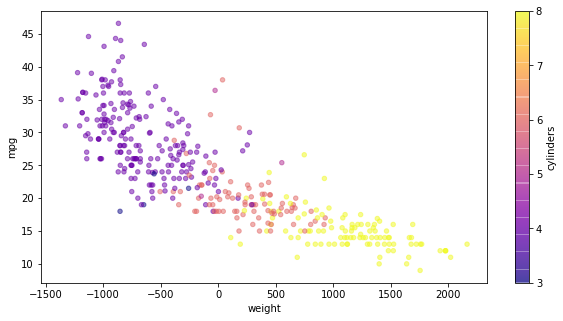

In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib nbagg
%matplotlib inline

data = pd.read_csv("auto-mpg.csv")
data["weight"] = data["weight"] - data["weight"].mean()
data["model year"] = data["model year"] - 70

fig, ax = plt.subplots(figsize=(10,5))
data.plot.scatter(x="weight", y="mpg", c="cylinders", cmap="plasma", alpha=0.5, ax=ax);

If we treat `cylinders` as a categorical variable and do not create any interaction terms, we are essentially saying that the relationship looks like this, with **parallel** slopes for each number of cylinders:

In [33]:
def plot_fit_lines(data, results, column, categories, interactions, cmap=mpl.colormaps['plasma']):
    # Extract some shorter variable names for readability
    x = data["weight"]
    beta_0 = results.params["const"]
    beta_1 = results.params["weight"]
    
    # Set up scatter plot
    fig, ax = plt.subplots(figsize=(10,5))
    data.plot.scatter(x="weight", y="mpg", c=column, cmap=cmap, alpha=0.5, ax=ax)

    colors = cmap
    min_cat = data[column].min()
    max_cat = data[column].max()
    range_cat = max_cat - min_cat
    
    # For each category, calculate and graph the fit line
    for cat in categories:
        if cat in interactions:
            fit_line = beta_0 + \
                (beta_1 + results.params[f"weight x {column}_{cat}"]) * x + \
                results.params[f"{column}_{cat}"]
        else:
            fit_line = beta_0 + beta_1 * x + results.params[f"{column}_{cat}"]
            
        ax.plot(
            x,
            fit_line,
            color=colors((cat - min_cat)/range_cat),
            label=f"{column}: {cat}",
            linewidth=5,
            alpha=0.7)

    ax.legend();

AttributeError: module 'matplotlib' has no attribute 'colormaps'

In [ ]:
import statsmodels.api as sm

# Prepare data for modeling
y = data["mpg"]
X_no_interaction = data[["cylinders", "weight"]].copy()

# Create dummy variables for the 'cylinders' column
X_no_interaction = pd.get_dummies(X_no_interaction, columns=["cylinders"], drop_first=True)

# Convert the dummy variables to numeric data type
X_no_interaction = X_no_interaction.astype(float)

# Build model and get results
no_interaction_model = sm.OLS(y, sm.add_constant(X_no_interaction))
no_interaction_results = no_interaction_model.fit()

# Plot the lines generated by the model for each selected category
plot_fit_lines(data, no_interaction_results, "cylinders", [4, 6, 8], [])

(Note that there are actually vehicles with 3, 4, 5, 6, or 8 cylinders, but since there are very few samples for 3 and 5 cylinders we'll just focus on those with 4, 6, or 8 cylinders.)

In formula form, we are saying:

$$ \large{ \text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \begin{cases}
  \beta_\text{(4 cylinders)} & \text{if 4 cylinders}, or\\
  \beta_\text{(6 cylinders)} & \text{if 6 cylinders}, or\\
  \beta_\text{(8 cylinders)} & \text{if 8 cylinders}.
\end{cases}} $$

If you had drawn the best-fit lines yourself, would you have drawn ones that look like this?

In particular, if you focus only on the cars with **4 cylinders**, does that line actually make sense with the scattered dots of that color? No, it seems like there should be a line with a steeper slope for 4 cylinders compared to 6 cylinders or 8 cylinders.

Adding an ***interaction term*** means that these slopes can differ depending on the number of cylinders, instead of just changing the intercepts! In other words, interaction terms mean that **the lines do not need to be parallel**.

## Adding an Interaction Term

Let's say that we are specifically concerned about the slope for cars with 4 cylinders. To do this, we'll add an interaction term that **multiplies** `weight` by `cylinders_4`.

Currently the data looks like this:

In [ ]:
X_no_interaction

We can add an interaction term between `weight` and `cylinders_4` like this:

In [ ]:
X_interaction = X_no_interaction.copy()
X_interaction["weight x cylinders_4"] = X_interaction["weight"] * X_interaction["cylinders_4"]
X_interaction

Then build a model and repeat the process of graphing the slopes:

In [ ]:
# Build model and get results
interaction_model = sm.OLS(y, sm.add_constant(X_interaction))
interaction_results = interaction_model.fit()


In [ ]:
interaction_results.params

In [ ]:
# Plot fit lines, this time with an interaction term
plot_fit_lines(data, interaction_results, "cylinders", [4, 6, 8], [4])

In formula form, we are now saying:

$$ \large{ \text{mpg} = \beta_0 + \begin{cases}
  \beta_1 \times \text{weight} + \beta_\text{interaction} + \beta_\text{(4 cylinders)} & \text{if 4 cylinders}, or\\
  \beta_1 \times \text{weight} + \beta_\text{(6 cylinders)} & \text{if 6 cylinders}, or\\
  \beta_1 \times \text{weight} + \beta_\text{(8 cylinders)} & \text{if 8 cylinders}.
\end{cases}} $$

Note that $\beta$s in this formula are not the same as in the previous formula. This is clear from the fact that the intercept for the 4 cylinders line $\beta_\text{(4 cylinders)}$ is higher in this graph than in the previous graph. Just like adding an additional independent variable to a multiple regression, adding an interaction fundamentally changes the model and the other coefficients will adjust accordingly.

## Evaluating the Addition of the Interaction Term

As with any modification to the independent variables of a regression model, we want to ensure that this actually improves the model. Does the interaction term (`weight` times `cylinders_4`) contribute different information to the model, compared to `weight` and `cylinders_4` individually?

The fact that this line _looks_ more correct is a good indicator that this interaction term was a good choice. The other things we'll want to check are:

1. Whether the interaction term coefficient is statistically significant
2. Whether this improved the model metrics overall

### Checking Coefficient Statistical Significance

We can check the p-values for all model coefficients using the code below:

In [ ]:
pvalues_df = pd.DataFrame(interaction_results.pvalues, columns=["p-value"])
pvalues_df["p < 0.05"] = pvalues_df["p-value"] < 0.05
pvalues_df

The `weight`, `cylinders_4`, **and** `weight x cylinders_4` coefficients are all statistically significant at an alpha of 0.05. This is an indicator that adding the interaction term was a good choice.

### Checking Model Metrics

Our original model had this adjusted R-Squared value:

In [ ]:
no_interaction_results.rsquared_adj

And our model with the interaction term had this adjusted R-Squared value:

In [ ]:
interaction_results.rsquared_adj

Once again it appears that adding the interaction term improved the model!

## Interpreting a Numeric x Categorical Interaction Term

Because the `const`, `cylinders_4`, `weight`, and `weight x cylinders_4` coefficients are all statistically significant, we can also interpret their meanings in the context of the model.

### Intercept Coefficients

In [ ]:
interaction_results.params["const"]

The value shown above corresponds with $\beta_0$ in the formula shown previously. This means that ***for the reference category number of cylinders (3 in this case) and average vehicle weight, we expect to see a fuel economy of about 18 miles per gallon***.

In [ ]:
interaction_results.params["cylinders_4"]

This value corresponds with $\beta_\text{(4 cylinders)}$. One way we could interpret it is that ***having 4 cylinders (as opposed to the reference category) is associated with an increase of about 5 mpg for a vehicle with average weight***. We also could add $\beta_0$ with $\beta_\text{(4 cylinders)}$:

In [ ]:
interaction_results.params["const"] + interaction_results.params["cylinders_4"]

This means that ***for vehicles with 4 cylinders and average vehicle weight, we expect to see a fuel economy of about 23 miles per gallon***.

### Multiplier Coefficients

In [ ]:
interaction_results.params["weight"]

The value shown above corresponds with $\beta_1$ in the formula shown previously. This means that ***for any number of cylinders other than 4*** (i.e. 3, 5, 6, or 8 cylinders) ***there is an associated decrease of about 0.004 miles per gallon for each additional pound of vehicle weight***.

In [ ]:
interaction_results.params["weight x cylinders_4"]

This means that ***for vehicles with 4 cylinders, there is an additional decrease of about 0.005 in miles per gallon for each additional pound of vehicle weight, above and beyond the decrease represented by $\beta_1$***.

We can also add the interaction coefficient to the other coefficient (`weight`):

In [ ]:
interaction_results.params["weight x cylinders_4"] + interaction_results.params["weight"]

This means that ***for vehicles with 4 cylinders, there is an associated decrease of about 0.009 miles per gallon for each additional pound of vehicle weight***.

Note that the larger decrease (0.009 compared to 0.004) corresponds to the steeper downward slope shown in the graph.

## Interactions with Numeric Features

It is also possible to create an interaction term between two numeric features rather than one numeric feature (e.g. `weight`) and one categorical feature (e.g. `cylinders_4`).

Let's take a look at `weight` vs. `model year`:

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
data.plot.scatter(x="weight", y="mpg", c="model year", cmap="viridis", alpha=0.5, ax=ax);

Just for the purposes of EDA, we could try binning the years to encode them as categorical variables, then plotting their fit lines.

In [ ]:
X_many_interactions = data[["weight", "model year"]].copy()
X_many_interactions = pd.get_dummies(X_many_interactions, columns=["model year"], drop_first=True)

# skip first year value because this was dropped in one-hot encoding
years = data["model year"].unique()[1:]

for year in years:
    X_many_interactions[f"weight x model year_{year}"] = X_many_interactions["weight"] * \
                                                            X_many_interactions[f"model year_{year}"]


In [ ]:
# Build model and get results
many_interactions_model = sm.OLS(y, sm.add_constant(X_many_interactions.astype(float)))
many_interactions_results = many_interactions_model.fit()

In [ ]:
# Plot many fit lines
# (Remember, a model year of 1 means 1971)
plot_fit_lines(data, many_interactions_results, "model year", years, years, cmap=mpl.colormaps['viridis'])

Looking at the plot above, we can see that there is a trend of steeper slopes for later model years. So rather than treating each of these model years as a separate category, let's treat `model year` as a numeric variable and create a single interaction term `weight x model year`: 

In [ ]:
# Prepare data with a single interaction term of weight x model year
X_numeric_interaction = data[["weight", "model year"]].copy()
X_numeric_interaction["weight x model_year"] = X_numeric_interaction["weight"] * X_numeric_interaction["model year"]
X_numeric_interaction

In [ ]:
# Build model and get results
numeric_interaction_model = sm.OLS(y, sm.add_constant(X_numeric_interaction))
numeric_interaction_results = numeric_interaction_model.fit()

To visualize how this model works, let's look at a 3D scatter plot, with the same x-axis (`weight`) and y-axis (`mpg`) as before, this time with a z-axis showing the `model year`. This is an interactive plot, so you can click and drag to see the data from different angles!

In [ ]:
%matplotlib nbagg
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    data["weight"],      # x axis
    data["mpg"],         # y axis
    data["model year"],  # z axis
    c=data["model year"],
    cmap="viridis"
)
ax.set_xlabel("weight")
ax.set_ylabel("mpg")
ax.set_zlabel("model year");

Now we can generate a plane of weights, years, and predictions, then plot that plane on the same axes as the scatter plot.

In [ ]:
import numpy as np

# Find 50 evenly-spaced points in the ranges of weight and model year and create meshes
weights = np.linspace(data["weight"].min(), data["weight"].max() + 1, 50)
years = np.linspace(data["model year"].min(), data["model year"].max() + 1, 50)
weights, years = np.meshgrid(weights, years)

# Extract relevant values from modeling results
constant = numeric_interaction_results.params["const"]
weight_coef = numeric_interaction_results.params["weight"]
year_coef = numeric_interaction_results.params["model year"]
interaction_coef = numeric_interaction_results.params["weight x model_year"]

# Make a hyperplane of predictions using the values extracted from the model
predictions = (
    # beta 0
    constant + \
    # beta 1 times weight
    weight_coef * weights + \
    # beta 2 times model year
    year_coef * years + \
    # beta 3 times weight times model year
    interaction_coef * weights * years
)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# Set up 3D scatter plot
ax.scatter(
    data["weight"],      # x axis
    data["mpg"],         # y axis
    data["model year"],  # z axis
    c=data["model year"],
    cmap="viridis"
)
ax.set_xlabel("weight")
ax.set_ylabel("model year")
ax.set_zlabel("mpg")

# Plot surface of predictions on the same axes
ax.plot_surface(
    weights,        # x
    predictions,    # y
    years,          # z
    cmap="viridis", # color is drawn from z axis value
    alpha=0.7
);

The formula being plotted here is:

$$ \large{ \text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \beta_2 \times \text{model year} + \beta_3 \times \text{weight} \times \text{model year} } $$

Note that the hyperplane is **curved** rather than a flat plane because of the interaction term.

If we just had the formula $\text{mpg} = \beta_0 + \beta_1 \times \text{weight} + \beta_2 \times \text{model year}$ (without the interaction term) then it would have been a flat plane made up of just a straight line with a slope of $\beta_1$ along the `weight` axis and a slope of $\beta_2$ along the `model year` axis.

## Interpreting a Numeric x Numeric Interaction Term

When both of the features used in the interaction are numeric, the interpretation is a little more tricky than with one numeric and one categorical feature. We can't just say "if `category`, there is a `coefficient` change in the target".

Instead, this kind of model is saying that the change in the target associated with the change in a given predictor is dependent on the value of another predictor!

Let's dive into some interpretations for the model shown above.

In [ ]:
numeric_interaction_results.pvalues

In [ ]:
numeric_interaction_results.params

### Intercept Coefficient

Compared to a model with categorical features, the interpretation of the intercept is fairly straightforward. The value of the `const` coefficient is about 19, which means that ***for a vehicle with average weight and a model year of 1970, we expect to see a fuel economy of about 19***.

(Remember that we subtracted the mean from `weight` and subtracted 70 from `model_year` in order to make intercepts like this more interpretable.)

### One-At-A-Time Interpretations

One way that we can interpret just the `weight` coefficient or just the `model_year` coefficient is by setting the value of the _other_ predictor to 0. That way you can ignore the `weight x model_year` beta altogether.

Thus we can say:

1. ***For a vehicle with a model year of 1970, there is a decrease of about 0.005 in mpg for each additional pound of vehicle weight.***
2. ***For a vehicle with average weight, there is an increase of about 0.7 mpg for each year newer of a model year.***

### Combined Interpretations

And what about a vehicle that does not have a model year of 1970, or is not of average weight? For that, we need to incorporate the `weight x model year` value, which is about 0.0005.

1. ***For each additional pound of vehicle weight, there is a decrease of about 0.005 + (0.0005 x model year) in mpg.***
2. ***For each year newer of a vehicle model, there is an increase of about 0.7 - (0.0005 x weight) in mpg.***

It will depend on the context whether the one-at-a-time or combined interpretation is more useful. There is a trade-off between how easy the explanation is to grasp vs. how much of the model it explains.

## Level Up: Interactions with Scikit-Learn

In the examples above we used `pandas` to create the interaction terms in our dataframes. This is simple enough if you want to have relatively few interaction terms, but what if you wanted to add every single possible pairwise combination of variables? `sklearn` allows you to make lots of interaction terms at once with the `PolynomialFeatures` class and `interaction_only` parameter ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)).

In [ ]:
# Prep subset of data for creating interactions
sklearn_data = data.drop("origin", axis=1).select_dtypes("number")
sklearn_data.rename(columns={"model year": "model_year"}, inplace=True)
sklearn_data

In [ ]:
# Separate X and y
y = sklearn_data["mpg"]
X = sklearn_data.drop("mpg", axis=1)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Fit a PolynomialFeatures transformer on X
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
poly.fit(X)

# Create transformed version of X that has all of the original features plus
# interactions between all features
new_col_names = pd.Series(poly.get_feature_names_out(X.columns)).str.replace(" ", " x ")
X_interactions = pd.DataFrame(poly.transform(X), columns=new_col_names)
X_interactions

As you might imagine, creating this many interaction terms will make the model much more difficult to interpret! Using scikit-learn like this typically only makes sense in a predictive analysis rather than an inferential one.

## Additional Resources

- You can use the Python library `seaborn` to visualize interactions as well. Have a look [here](https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6) for more information.
- [This resource](http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-621/interaction.pdf) walks over multiple examples of regressions with interaction terms. Even though the code is in R, it might give you some additional insights into how interactions work.
- [This resource](http://joelcarlson.github.io/2016/05/10/Exploring-Interactions/) also uses R but has several visualizations of interactions with the auto MPG dataset specifically!

## Summary

Great! You now know how to describe interactions, how to include them in your model and how to interpret them. You'll practice what you learned here in the next lab.  